# Model Persistence

머신러닝 모델을 학습시킨 후, 모델 재사용을 위해 저장하고 로드하는 방법을 알아봅니다. 

## Scikit-Learn

Scikit-Learn 에서는 학습 후 모델을 저장하기 위해 joblib 모듈을 제공해 줍니다. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import numpy as np
from sklearn import datasets, model_selection, linear_model, metrics
import os, joblib

# 데이터
np.random.seed(0)
n_samples = 100000
np_data_xs, np_data_ys = datasets.make_classification(
    n_samples=n_samples, # 데이터 수
    n_features=10, # X feature 수
    n_informative=3,
    n_classes=3, # Y class 수
    random_state=0) # 난수 발생용 Seed 값
print("data shape: np_data_xs={}, np_data_ys={}".format(np_data_xs.shape, np_data_ys.shape))
np_train_xs, np_test_xs, np_train_ys, np_test_ys = model_selection.train_test_split(
    np_data_xs, np_data_ys, 
    test_size=0.3, shuffle=True, random_state=2)
print("train shape: np_train_xs={}, np_train_ys={}".format(np_train_xs.shape, np_train_ys.shape))
print("test shape: np_test_xs={}, np_test_ys={}".format(np_test_xs.shape, np_test_ys.shape))

# 모델
model = linear_model.LogisticRegression(solver='sag', multi_class='multinomial')

# 학습
print("model={}".format(model))
model.fit(np_train_xs, np_train_ys)

# 평가
np_pred_ys = model.predict(np_test_xs)
cr = metrics.classification_report(np_test_ys, np_pred_ys)
print("classification_report\n", cr)

# 모델 저장/로드
path_model = "/tmp/model.joblib"
joblib.dump(model, path_model)
model = joblib.load(path_model)

# 재평가
np_pred_ys = model.predict(np_test_xs)
cr = metrics.classification_report(np_test_ys, np_pred_ys)
print("classification_report\n", cr)

data shape: np_data_xs=(100000, 10), np_data_ys=(100000,)
train shape: np_train_xs=(70000, 10), np_train_ys=(70000,)
test shape: np_test_xs=(30000, 10), np_test_ys=(30000,)
model=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='sag',
          tol=0.0001, verbose=0, warm_start=False)
classification_report
               precision    recall  f1-score   support

           0       0.77      0.79      0.78     10004
           1       0.77      0.72      0.74     10004
           2       0.88      0.91      0.89      9992

   micro avg       0.81      0.81      0.81     30000
   macro avg       0.81      0.81      0.81     30000
weighted avg       0.81      0.81      0.81     30000

classification_report
               precision    recall  f1-score   support

           0       0.77      0.79      0.78     10004
           1   

## Keras

참조: https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model

### 전체 모델 저장하기/불러오기 (architecture + weights + optimizer state)

Keras 모델을 하나의 HD5 파일 형식으로 하나의 파일에 저장하고 불러올 수 있습니다. 저장되는 정보는 아래와 같습니다.

* the architecture of the model, allowing to re-create the model
* the weights of the model
* the training configuration (loss, optimizer)
* the state of the optimizer, allowing to resume training exactly where you left off.

```python
from keras.models import load_model

model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'
del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
model = load_model('my_model.h5')
```

### 모델 구조만 저장하기/불러오기

JSON 또는 YAML 형태로 모델을 저장하고 불러올 수 있습니다.

```python
from keras.models import model_from_json
from keras.models import model_from_yaml

# JSON
json_string = model.to_json()
model = model_from_json(json_string)

# YAML
yaml_string = model.to_yaml()
model = model_from_yaml(yaml_string)
```

### 모델 가중치만 저장하기/불러오기

모델을 학습시킨 결과 가중치만 HDF5 형식으로 저장하고 불러올 수 있습니다. 저장된 가중치를 사용하기 위해서는 저장한 모델의 구조가 동일해야 합니다

```python
model.save_weights('my_model_weights.h5')
model.load_weights('my_model_weights.h5')
```

Fine-tuning 또는 Transfer-learning 과 같이 불러온 가중치를 다른 모델에서 사용해야 할 경우에는 layer 의 이름을 통해 해당 layer 의 가중치만 불러오기도 가능합니다.

```python
"""
Assuming the original model looks like this:
    model = Sequential()
    model.add(Dense(2, input_dim=3, name='dense_1'))
    model.add(Dense(3, name='dense_2'))
    ...
    model.save_weights(fname)
"""

# new model
model = Sequential()
model.add(Dense(2, input_dim=3, name='dense_1'))  # will be loaded
model.add(Dense(10, name='new_dense'))  # will not be loaded

# load weights from first model; will only affect the first layer, dense_1.
model.load_weights(fname, by_name=True)
```

### 모델에 custom layers (or other custom objects) 포함된 경우

자신만의 모델을 위해 custom layer/object/function 를 작성한 경우, 모델을 불러올 때는 해당 정보를 모델에 넘겨 줘야 합니다.

```python
from keras.models import load_model
# Assuming your model includes instance of an "AttentionLayer" class
model = load_model('my_model.h5', custom_objects={'AttentionLayer': AttentionLayer})

from keras.utils import CustomObjectScope
# Alternatively, you can use a custom object scope:
with CustomObjectScope({'AttentionLayer': AttentionLayer}):
    model = load_model('my_model.h5')

from keras.models import model_from_json
# Custom objects handling works the same way for load_model, model_from_json, model_from_yaml:
model = model_from_json(json_string, custom_objects={'AttentionLayer': AttentionLayer})
```

### 모델 생성시 Class 를 사용한 경우

코드의 가독성을 위해 Keras 모델을 상속하여 모델 클래스를 만든 경우는 모델의 가중치 값만을 저장하고 불러올 수 있습니다.

Using TensorFlow backend.


data shape: np_data_xs=(10000, 10), np_data_ys=(10000,)
train shape: np_train_xs=(7000, 10), np_train_ys=(7000,)
test shape: np_test_xs=(3000, 10), np_test_ys=(3000,)

model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                176       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 51        
Total params: 609
Trainable params: 609
Non-trainable params: 0
_________________________________________________________________


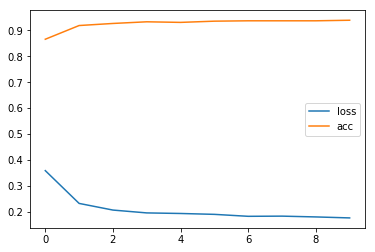

acc=0.92933
classification_report
               precision    recall  f1-score   support

           0       0.92      0.91      0.92      1021
           1       0.93      0.91      0.92      1011
           2       0.94      0.96      0.95       968

   micro avg       0.93      0.93      0.93      3000
   macro avg       0.93      0.93      0.93      3000
weighted avg       0.93      0.93      0.93      3000

acc=0.92933
classification_report
               precision    recall  f1-score   support

           0       0.92      0.91      0.92      1021
           1       0.93      0.91      0.92      1011
           2       0.94      0.96      0.95       968

   micro avg       0.93      0.93      0.93      3000
   macro avg       0.93      0.93      0.93      3000
weighted avg       0.93      0.93      0.93      3000



In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import numpy as np
from sklearn import datasets, preprocessing, model_selection, metrics
from keras import models, layers, optimizers, utils

# 데이터
np.random.seed(0)
n_samples = 10000
n_features = 10
n_class = 3
np_data_xs, np_data_ys = datasets.make_classification(
    n_samples=n_samples, # 데이터 수
    n_features=n_features, # X feature 수
    n_informative=n_class,
    n_classes=3, # Y class 수
    random_state=0) # 난수 발생용 Seed 값
print("data shape: np_data_xs={}, np_data_ys={}".format(np_data_xs.shape, np_data_ys.shape))
np_train_xs, np_test_xs, np_train_ys, np_test_ys = model_selection.train_test_split(
    np_data_xs, np_data_ys, 
    test_size=0.3, shuffle=True, random_state=2)
print("train shape: np_train_xs={}, np_train_ys={}".format(np_train_xs.shape, np_train_ys.shape))
print("test shape: np_test_xs={}, np_test_ys={}".format(np_test_xs.shape, np_test_ys.shape))

# 전처리
scaler_xs = preprocessing.StandardScaler()
np_train_scale_xs = scaler_xs.fit_transform(np_train_xs)
np_test_scale_xs = scaler_xs.transform(np_test_xs)

np_train_onehot_ys = utils.np_utils.to_categorical(np_train_ys, n_class)
np_test_onehot_ys = utils.np_utils.to_categorical(np_test_ys, n_class)

# 모델
class DnnClassifier(models.Sequential):
    def __init__(self, n_i, n_hs, n_o):
        super().__init__()
        self.add(layers.Dense(n_i, activation='relu', input_shape=(n_i,)))
        for l, n_h in enumerate(n_hs):
            self.add(layers.Dense(n_h, activation='relu'))
        self.add(layers.Dense(n_o, activation = 'softmax'))
        sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
        self.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

model = DnnClassifier(n_i = n_features, n_hs = [16, 16], n_o = n_class)

# 학습
print("\nmodel")
model.summary()
history = model.fit(np_train_scale_xs, np_train_onehot_ys, epochs=10, batch_size=10, verbose=0)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['acc'], label='acc')    
plt.legend()
plt.show()    

# 평가
np_pred_ys = model.predict_classes(np_test_scale_xs)

acc = metrics.accuracy_score(np_test_ys, np_pred_ys)
print("acc={:.5f}".format(acc))

cr = metrics.classification_report(np_test_ys, np_pred_ys)
print("classification_report\n", cr)

# 모델 저장/로드
model.save_weights('/tmp/my_model.h5')  # creates a HDF5 file 'my_model.h5'
del model  # deletes the existing model

model = DnnClassifier(n_i = n_features, n_hs = [16, 16], n_o = n_class)
model.load_weights('/tmp/my_model.h5')

# 재평가
np_pred_ys = model.predict_classes(np_test_scale_xs)

acc = metrics.accuracy_score(np_test_ys, np_pred_ys)
print("acc={:.5f}".format(acc))

cr = metrics.classification_report(np_test_ys, np_pred_ys)
print("classification_report\n", cr)